In [2]:
import os
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten
import tensorflow as tf
import tensorflow_io as tfio
from flask import Flask, render_template
import base64
from io import BytesIO
from matplotlib.figure import Figure
import numpy as np

In [4]:
healthy_aud=os.path.join('N:','Poultry_Data','Healthy','2.wav')
unhealthy_aud=os.path.join('N:','Poultry_Data','Unhealthy','2.wav')
noise_aud=os.path.join('N:','Poultry_Data','Noise','2.wav')

In [5]:
def load_wave(filename):
    file_contents=tf.io.read_file(filename)
    wav,sample_rate=tf.audio.decode_wav(file_contents,desired_channels=1)
    wav=tf.squeeze(wav,axis=-1)
    sample_rate=tf.cast(sample_rate,dtype=tf.int64)
    wav=tfio.audio.resample(wav,rate_in=sample_rate,rate_out=16000)
    '''plt.figure()
    plt.plot(wav.numpy())'''
    return wav

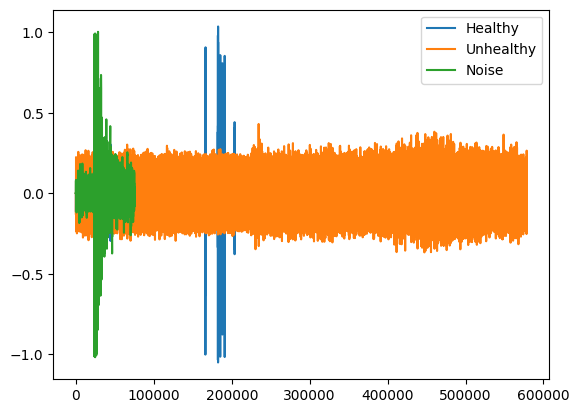

In [10]:
wav_h=load_wave(healthy_aud)
wav_uh=load_wave(unhealthy_aud)
wav_n=load_wave(noise_aud)
plt.plot(wav_h, label="Healthy")
plt.plot(wav_uh,label="Unhealthy")
plt.plot(wav_n, label="Noise")
plt.legend()
plt.show()


In [13]:
healthy=os.path.join('N:','Poultry_Data','Healthy')
unhealthy=os.path.join('N:','Poultry_Data','Unhealthy')
noise=os.path.join('N:','Poultry_Data','Noise')

h=tf.data.Dataset.list_files(healthy+"\*.wav")
unh=tf.data.Dataset.list_files(unhealthy+"\*.wav")
n=tf.data.Dataset.list_files(noise+"\*.wav")

negatives_1=tf.data.Dataset.zip((h,tf.data.Dataset.from_tensor_slices(tf.zeros(len(h)))))
positives=tf.data.Dataset.zip((unh,tf.data.Dataset.from_tensor_slices(tf.ones(len(unh)))))
negatives_2=tf.data.Dataset.zip((n,tf.data.Dataset.from_tensor_slices(tf.zeros(len(n)))))

data= positives.concatenate(negatives_1).concatenate(negatives_2)

In [14]:
data.shuffle(1000).as_numpy_iterator().next()

(b'N:Poultry_Data\\Healthy\\43.wav', 0.0)

In [15]:
length=[]
for file in os.listdir(os.path.join('N:','Poultry_Data','Healthy')):
    tensor_wave=load_wave(os.path.join('N:','Poultry_Data','Healthy',file))
    length.append(len(tensor_wave))
#mean length=40,000. Choosing 48000 samples as higher sample

In [16]:
def preprocess(file_path,label):
    wave=load_wave(file_path)
    wave=wave[:48000]
    zero_padding=tf.zeros([48000]-tf.shape(wave),dtype=tf.float32)
    wave=tf.concat([zero_padding,wave],0)
    spectrogram=tf.signal.stft(wave,frame_length=320, frame_step=32)
    spectrogram=tf.abs(spectrogram)
    spectrogram=tf.expand_dims(spectrogram,axis=2)
    return spectrogram,label

b'N:Poultry_Data\\Healthy\\47.wav'


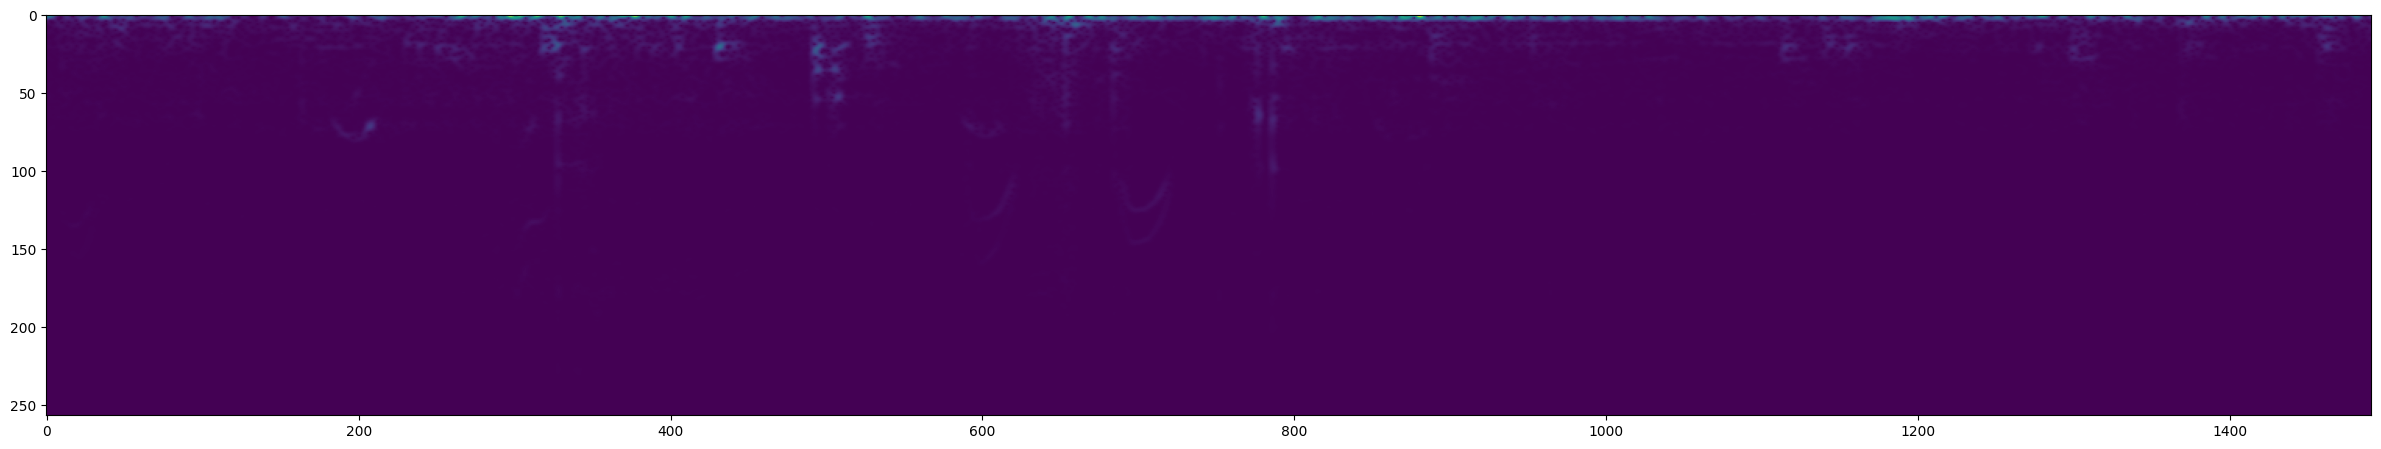

316
(b'N:Poultry_Data\\Unhealthy\\76.wav', 1.0)


In [17]:
file_path,label=data.shuffle(1000).as_numpy_iterator().next()
print(file_path)
spectogram,label=preprocess(file_path,label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectogram)[0])
plt.show()
print(len(data))
print(data.shuffle(1000).as_numpy_iterator().next())

In [18]:
data=data.map(preprocess)
data=data.cache()
data=data.shuffle(buffer_size=1000)
data=data.batch(16)
data=data.prefetch(8)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [12]:
len(data)

20

In [19]:
train=data.take(14)
test=data.skip(14).take(6)
print(train)
samples,lables=train.as_numpy_iterator().next()
samples.shape

<TakeDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


(16, 1491, 257, 1)

In [20]:
model=Sequential()
model.add(Conv2D(10,(3,3),activation="relu",input_shape=(1491,257,1)))
model.add(Conv2D(10,(3,3),activation="relu"))
model.add(Flatten())
model.add(Dense(86,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.compile("Adam",loss="BinaryCrossentropy",metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 10)     100       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 10)     910       
                                                                 
 flatten (Flatten)           (None, 3762110)           0         
                                                                 
 dense (Dense)               (None, 86)                323541546 
                                                                 
 dense_1 (Dense)             (None, 1)                 87        
                                                                 
Total params: 323,542,643
Trainable params: 323,542,643
Non-trainable params: 0
_________________________________________________________________


In [21]:
hist=model.fit(train,epochs=4,validation_data=test)

Epoch 1/4


14/14 [==============================] - 116s 8s/step - loss: 7.1021 - recall: 0.7439 - precision: 0.5922 - val_loss: 1.8885 - val_recall: 1.0000 - val_precision: 0.4407
Epoch 2/4
14/14 [==============================] - 93s 7s/step - loss: 0.4744 - recall: 0.8923 - precision: 0.8056 - val_loss: 0.1547 - val_recall: 0.9412 - val_precision: 0.9412
Epoch 3/4
14/14 [==============================] - 89s 6s/step - loss: 0.1570 - recall: 0.9625 - precision: 0.9059 - val_loss: 0.0159 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
14/14 [==============================] - 90s 6s/step - loss: 0.0783 - recall: 0.9762 - precision: 0.9762 - val_loss: 0.2087 - val_recall: 0.9697 - val_precision: 0.9412


In [15]:
x_test,y_test=test.as_numpy_iterator().next()
y_hat=model.predict(x_test)
x_test[0].shape
test

1/1 [==============================] - 1s 1s/step


<TakeDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [39]:
c=0
for i in y_hat:
    if(i>0.5):
        c+=1
c

2

In [40]:
c=0
for i in y_test:
    if(i>0.5):
        c+=1
c

2

In [ ]:
''' Still left to do:
join preprocess and figure out a way to say which batch is sick
How is data passed here
How will it be passed from here
'''

In [27]:
y_test

array([0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1.],
      dtype=float32)

In [23]:

def parser_model(file_path):
    def preprocessing(file_path):
        wave=load_wave(file_path)
        wave=wave[:48000]
        zero_padding=tf.zeros([48000]-tf.shape(wave),dtype=tf.float32)
        wave=tf.concat([zero_padding,wave],0)
        spectrogram=tf.signal.stft(wave,frame_length=320, frame_step=32)
        spectrogram=tf.abs(spectrogram)
        spectrogram=tf.expand_dims(spectrogram,axis=2)
        return spectrogram
    
    data=file_path
    data=tf.data.Dataset.list_files(file_path+"\*.wav")
    data=data.map(preprocessing)
    data=data.cache()
    data=data.shuffle(buffer_size=1000)
    print("Total Dataset:",len(data))
    data=data.batch(16)
    data=data.prefetch(8)
    count=0
    c=0
    print("Total batches of 16:",len(data))
    for i in range(len(data)):
        mod=data.as_numpy_iterator().next()
        op=model.predict(mod)
        for j in op:
            c+=1
            if j>0.5:
                count+=1
    print(count," Chickens out of", c, "are unhealthy")
    return count
        


In [24]:
fin=os.path.join('N:','Poultry_Data','Final_Parsing')
num=parser_model(fin)
#print(c," Chickens out of", total, "are unhealthy")



Total Dataset: 30
Total batches of 16: 2
1/1 [==============================] - 1s 956ms/step
10  Chickens out of 32 are unhealthy


In [28]:
app=Flask(__name__)
@app.route("/")
def hello():
    no_of_unhealthy=[2,0,3,3,0,0,1,1,2,1,0]
    no_of_unhealthy.append(num)
    no_of_days=[i for i in range(1,len(no_of_unhealthy)+1)]
    plt.plot(no_of_days,no_of_unhealthy,marker ='o', markersize = 12) 
    plt.xlabel("Days")
    plt.ylabel("No of Unhealthy Chickens")
    plt.savefig('./static/images/new_plot.png')
    return render_template('index.html',c=num, url="./static/images/new_plot.png")

In [29]:
if(__name__=="__main__"):
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
[2023-11-08 10:08:17,302] ERROR in app: Exception on / [GET]
Traceback (most recent call last):
  File "c:\Users\charu\AppData\Local\Programs\Python\Python310\lib\site-packages\flask\app.py", line 1455, in wsgi_app
    response = self.full_dispatch_request()
  File "c:\Users\charu\AppData\Local\Programs\Python\Python310\lib\site-packages\flask\app.py", line 869, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "c:\Users\charu\AppData\Local\Programs\Python\Python310\lib\site-packages\flask\app.py", line 867, in full_dispatch_request
    rv = self.dispatch_request()
  File "c:\Users\charu\AppData\Local\Programs\Python\Python310\lib\site-packages\flask\app.py", line 852, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "C:\Users\charu\AppData\Local\Temp\ipykernel_9344\2171515058.py", line 11, in hello
    return render_template('index.html',c=num, url="./st